In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

[*********************100%***********************]  1 of 1 completed


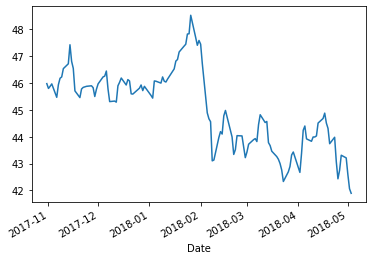

In [156]:
import yfinance as yf

# Get the data for the stock 
data = yf.download('KO','2017-11-01','2018-05-04')
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the close price
data['Close']
data['Close'].plot()
plt.show()

In [157]:
returns=data['Close'].pct_change()

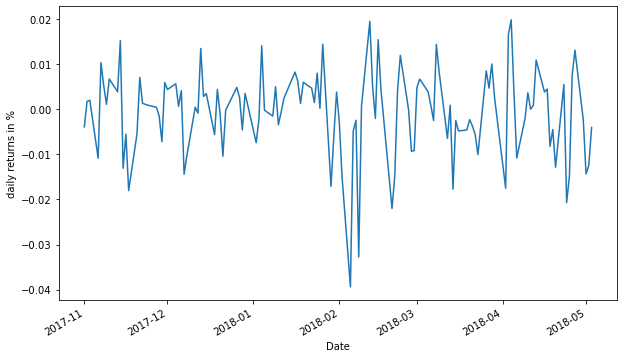

In [158]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    returns.plot(figsize=(10, 6))
    plt.ylabel("daily returns in %");

In [159]:
prior_coords = {'date': returns.index}

In [160]:
import pymc3 as pm

with pm.Model(coords=prior_coords) as KOusd_model:
    # The model remembers the datetime index with the name 'date'
    change_returns = returns

    nu = pm.Exponential("nu", 1 / 10.0, testval=5.0)
    sigma = pm.Exponential("sigma", 2.0, testval=0.1)

    # We can now figure out the shape of variables based on the
    # index of the dataset
    s = pm.GaussianRandomWalk("s", sigma=sigma, dims='date')
    # instead of:
    # s = pm.GaussianRandomWalk('s', sigma, shape=len(returns))
    volatility_process = pm.Deterministic(
        "volatility_process", pm.math.exp(-2 * s) ** 0.5, dims='date'
    )

    r = pm.StudentT("r", nu=nu, sigma=volatility_process, observed=change_returns, dims='date')

/opt/miniconda3/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in r contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [161]:
with KOusd_model:
    trace = pm.sample(2000, init="adapt_diag", return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r_missing, s, sigma, nu]


/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 144 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


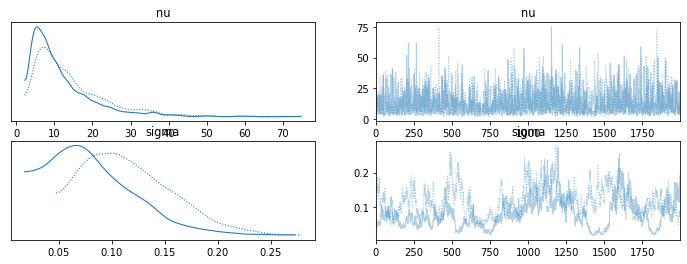

In [162]:
import arviz as az

with KOusd_model:
    az.plot_trace(trace, var_names=["nu", "sigma"]);

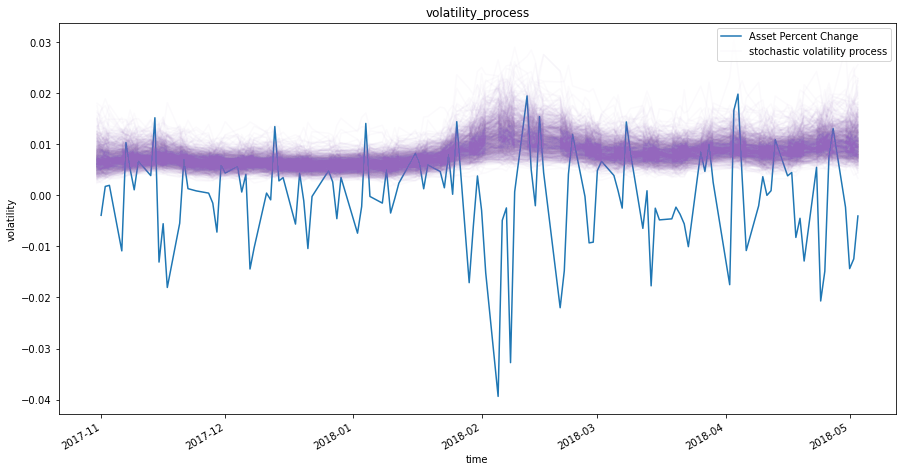

In [163]:
fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
ax.plot(returns.index, 1 / np.exp(trace["s", ::5].T), "C4", alpha=0.03)
ax.set(title="volatility_process", xlabel="time", ylabel="volatility")
ax.legend(["Asset Percent Change","stochastic volatility process"], loc="upper right")